### HMM EXERCISE 1 

**Author:** Dirk Van Compernolle      

**History:**  
- 14/11/2019 created   
- 16/06/2021 adapted to pyspch (2021)   

**Dependencies:**
- pyspch   

In [11]:
# check the environment and add installs as needed
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

try:
    import pyspch
except:
    ! pip install git+https://github.com/compi1234/pyspeech.git
    import pyspch

In [12]:
# do all the imports
%matplotlib inline

import sys, os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import pyspch.libhmm as libhmm
import pyspch.utils as u
import pyspch.libhmm_plot as hmmplot

In [ ]:
# graphical and print preferences
ldesign = 50
cmap = sns.light_palette("caramel",ldesign,input="xkcd")
cmap20 = cmap[0:20] 
pd.reset_option('display.float_format')
pd.set_option('precision',3)

### Design of a 2-state silence-speech model
We are creating a very minimal 2-state discrete Hidden Markov Model
- we define the 2 states and give them a name: {SIL, SP}
- we define a set of labels as possible observation symbols {A,B,C}  
- we define the Amat, Bmat matrices that specify the transition probabilities and the emission probabilities
- finally we need to set assumption on start and end of the sequence
    + we assume that all sequences will start in the SIL state (implicitly set in the model creation)
    + we also assume that all sequences will end in SIL; the admmissible end states are specified in end_states[]
- As output we print all model parameters

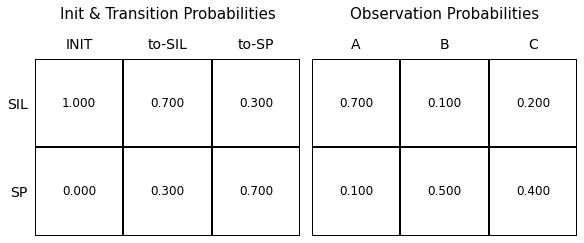

In [21]:
Bmat = np.array([ [0.7, 0.1, 0.2], [0.1, 0.5, 0.4] ])
Amat = np.array([[0.7, 0.3],[0.3,0.7]])
hmm1 = libhmm.DHMM(n_states=2,states=['SIL','SP'],n_symbols=3,labels=['A','B','C'],
                   emissionprob=Bmat, transmat=Amat )   
# force an alignment to end in SIL state
hmm1.end_states=[0]
#hmm1.print_model()
hmmplot.plot_model(hmm1,figsize=(8,4))

### Model Evaluation using the Viterbi Algorithm
Hidden Markov Models are probabilistic models used for sequence recognition.   
Given an HMM, the most elementary question is "What is the probability that a sequence came from a particular model?"   There are 2 algorithms available to answer this question:
- The VITERBI algorithm: finds both the likelihood score along that path
    + with some extra work, it gives the most likely path (state vs observation alignment) as well
    + it is the most commonly used algorithm for recognition purposes
- The FORWARD PASS algorithm: finds the true probability that a model generated a given sequence
    + it sums the probabilities over all possible paths
    + it does not provide an alignment
    + it is mainly used for training models in the FORWARD-BACKWARD algorithm
    
In the next example a short sequence is evaluated against the model using Viterbi. Several stages are highlighted:
- FRAME PROBABILITIES: 
    + these are the likelihood of an observation in a state
    + they are computed from the Observation Probabilities and the Observations 
- TRELLIS: 
    + in a TRELLIS you can read the likelihood of being in a state at a given time and having observed all the observations from the start till here
    + the TRELLIS is filled in a time synchronous way by aggregating the FRAME PROBABILITIES with the transition model 

In [22]:
X1 = np.array([  0, 1, 2, 0])
print("OBSERVATION SEQUENCE:\n ",hmm1.labels[X1],"\n")
trellis1 = libhmm.Trellis(n_samples=len(X1),n_states=hmm1.n_states)
trellis1.viterbi_pass(X1,hmm1)
trellis1.print(Xlabels=hmm1.labels[X1],Slabels=hmm1.states)

OBSERVATION SEQUENCE:
  ['A' 'B' 'C' 'A'] 

FRAME PROBABILIITIES and TRELLIS


,A,B,C,A
SIL,0.7,0.1,0.2,0.7
SP,0.1,0.5,0.4,0.1


,A,B,C,A
SIL,0.7,0.049,0.007,0.006
SP,0.0,0.105,0.029,0.002


BACKPOINTERS


,A,B,C,A
SIL,0,0,0,1
SP,1,0,1,1


ALIGNMENT


,0,1,2,3
X,A,B,C,A
BT,SIL,SP,SP,SIL


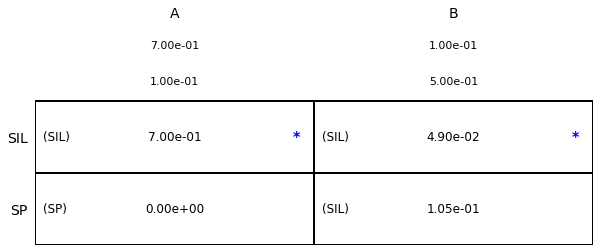

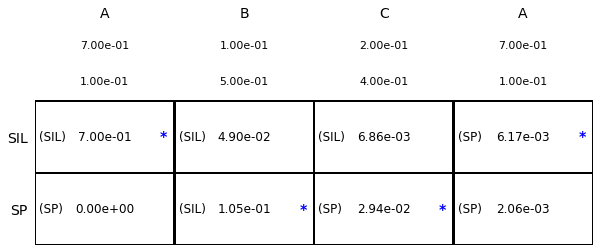

In [37]:

print("\n\n")

hmmplot.plot_trellis2(hmm1,X1,cmap=[],vmin=0,vmax=1,fmt=".2e",
        plot_norm=True,plot_frameprobs=True,plot_backptrs=True,
        plot_alignment=True,figsize=(10,4))

### A Continuous Density Model
The **discrete density** model has symbols as observations and simple discrete density observation probabilities in the Bmat.
In a **continous density** model has continuous feature vectors as observations requiring a density model to map from 
observation to probability of the observation.  In traditional HMMs Gaussian Mixtures were the most
popular density models.  These days, the modeling will rather be done by a Deep Neural Network.   

For simplicity reasons we start out with a simpe single one dimensional Gaussian density.
Except for the computation of the FRAME PROBABILITIES all other steps are identical to the discrete density model.

In [34]:
def gpdf(x,mu,sig):
    z = (x-mu)/sig
    ss = 1./(np.sqrt(2.*np.pi)*sig)
    return(ss * np.exp(-0.5*z*z))
def cdprobs(xlist):
    pdf1 = np.array([gpdf(x,20,10) for x in xlist]).reshape(-1,1)
    pdf2 = np.array([gpdf(x,50,20) for x in xlist]).reshape(-1,1)
    return( np.hstack([pdf1 , pdf2]) )

FRAME PROBABILIITIES and TRELLIS


,X0,X1,X2,X3
SIL,0.035,0.013,1.338e-05,0.035
SP,0.004,0.015,1.760e-02,0.009


,X0,X1,X2,X3
SIL,0.035,3.192e-04,2.990e-09,2.070e-08
SP,0.000,1.590e-04,1.960e-06,1.253e-08


BACKPOINTERS


,X0,X1,X2,X3
SIL,0,0,0,1
SP,1,0,1,1


ALIGNMENT


,0,1,2,3
X,X0,X1,X2,X3
BT,SIL,SP,SP,SIL


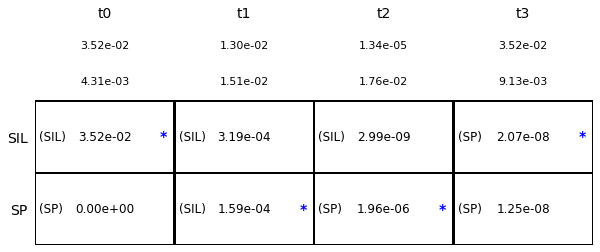

In [35]:
X2 =  [15., 35., 60.,25.]
X2probs = cdprobs(X2)
#print(X2probs.shape,X2probs)
hmm2 =  libhmm.DirectHMM(n_states=2,states=['SIL','SP'],transmat=Amat ) 
trellis2 = libhmm.Trellis(n_samples=len(X2),n_states=hmm1.n_states)
trellis2.viterbi_pass(X2probs,hmm2)
trellis2.print(Slabels=hmm1.states)
print("\n\n")
hmmplot.plot_trellis2(hmm2,X2probs,cmap=[],vmin=0,vmax=1,fmt=".2e",
        plot_norm=True,plot_frameprobs=True,plot_backptrs=True,
        plot_alignment=True,figsize=(10,4))

### Training of a Discrete Density Model

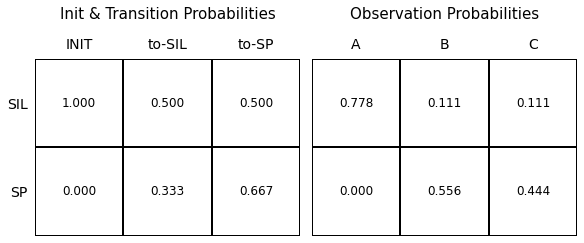

In [28]:
# Sample training code for discrete density training
#
X2=[1,0,1,1,2,0]
X3=[0,1,2,1,2,0,2,0]
S2=[0,0,1,1,1,0]
S3=[0,1,1,1,1,0,0,0]
train_set = []
train_set.append({'X':X1,'S':trellis1.alignment})
train_set.append({'X':X2,'S':S2})
train_set.append({'X':X3,'S':S3})

def viterbi_train(trn,n_labels=1,n_states=1):
    n_train = len(trn)
    obs_counts = np.zeros((n_states,n_labels),dtype='float')
    init_counts = np.zeros(n_states,dtype='float')
    trans_counts = np.zeros((n_states,n_states),dtype='float')
    # counting
    for i in range(0,n_train):
        init_counts[trn[i]["S"][0]] += 1.
        for j in range(len(trn[i]["X"])):
            obs_counts[trn[i]["S"][j],trn[i]["X"][j]] += 1.
            if j>0:
                trans_counts[ trn[i]["S"][j-1],trn[i]["S"][j] ] += 1.
    state_counts = np.sum(obs_counts,axis=1)
    op = obs_counts / state_counts[:,np.newaxis]
    tp = trans_counts / np.sum(trans_counts,axis=1)[:,np.newaxis]
    ip = init_counts / np.sum(init_counts)
    return op,tp,ip

op, tp, ip = viterbi_train(train_set,n_labels=3,n_states=2)
hmm_retrained = libhmm.DHMM(n_states=2,states=['SIL','SP'],n_symbols=3,labels=['A','B','C'],
                   emissionprob=op, transmat=tp, startprob=ip )
hmmplot.plot_model(hmm_retrained,figsize=(8,4))
